In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0518_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0830

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - loss: 0.0738
Average validation loss: 0.12553516030311584
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 0.0738 - val_loss: 0.1255
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 549ms/step - loss: 0.0549 - val_loss: 0.1255
Average validation loss: 0.1167794018983841
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - loss: 0.0549 - val_loss: 0.1212
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - loss: 0.0421 - val_loss: 0.1212
Average validation loss: 0.11337494850158691
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 550ms/step - loss: 0.0421 - val_loss: 0.1186
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_5.pth'.
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - loss: 0.0343 - val_loss: 0.1186
Aver

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 950ms/step - loss: 0.0033
Average validation loss: 0.15692858397960663
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 959ms/step - loss: 0.0033 - val_loss: 0.1569
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 819ms/step - loss: 0.0034 - val_loss: 0.1569
Average validation loss: 0.2860862463712692
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 833ms/step - loss: 0.0034 - val_loss: 0.2215
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 829ms/step - loss: 0.0032 - val_loss: 0.2215
Average validation loss: 0.20310135185718536
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 845ms/step - loss: 0.0032 - val_loss: 0.2154
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 825ms/step - loss: 0.0031 - val_loss: 0.2154
Average validation loss: 0.21454020589590073
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 840ms/step - loss: 0.0031 - val_loss: 0.2152
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 985ms/step - loss: 0.0030 - val_loss: 0.2152
Average validation 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 841ms/step - loss: 0.0021
Average validation loss: 0.1712830513715744
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 855ms/step - loss: 0.0021 - val_loss: 0.1713
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 877ms/step - loss: 0.0019 - val_loss: 0.1713
Average validation loss: 0.19653373956680298
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 892ms/step - loss: 0.0019 - val_loss: 0.1839
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 871ms/step - loss: 0.0018 - val_loss: 0.1839
Average validation loss: 0.15774807333946228
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 884ms/step - loss: 0.0018 - val_loss: 0.1752
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 878ms/step - loss: 0.0016 - val_loss: 0.1752
Average validation loss: 0.1590569019317627
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 893ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 867ms/step - loss: 8.1055e-04
Average validation loss: 0.1505734622478485
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 880ms/step - loss: 8.1055e-04 - val_loss: 0.1506
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 830ms/step - loss: 7.1596e-04 - val_loss: 0.1506
Average validation loss: 0.2650354206562042
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 844ms/step - loss: 7.1596e-04 - val_loss: 0.2078
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - loss: 6.4914e-04 - val_loss: 0.2078
Average validation loss: 0.16213950887322426
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 847ms/step - loss: 6.4914e-04 - val_loss: 0.1926
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 832ms/step - loss: 6.8038e-04 - val_loss: 0.1926
Average validation loss: 0.15684976428747177
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 844ms/step - loss: 6.8038e-04 - val_loss: 0.1836
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 68s 812ms/step - 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - loss: 0.0014
Average validation loss: 0.15407007932662964
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 828ms/step - loss: 0.0014 - val_loss: 0.1541
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 797ms/step - loss: 0.0012 - val_loss: 0.1541
Average validation loss: 0.1455850660800934
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - loss: 0.0012 - val_loss: 0.1498
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 801ms/step - loss: 0.0010 - val_loss: 0.1498
Average validation loss: 0.1977017939090729
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 814ms/step - loss: 0.0010 - val_loss: 0.1658
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 826ms/step - loss: 8.7281e-04 - val_loss: 0.1658
Average validation loss: 0.15288268625736237
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 837ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - loss: 0.0012
Average validation loss: 0.18877945095300674
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - loss: 0.0012 - val_loss: 0.1888
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 822ms/step - loss: 9.2798e-04 - val_loss: 0.1888
Average validation loss: 0.22404807806015015
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 833ms/step - loss: 9.2798e-04 - val_loss: 0.2064
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 796ms/step - loss: 8.1265e-04 - val_loss: 0.2064
Average validation loss: 0.17488274474938711
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 807ms/step - loss: 8.1265e-04 - val_loss: 0.1959
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 796ms/step - loss: 7.3221e-04 - val_loss: 0.1959
Average validation loss: 0.2295127660036087
24/24 ━━━━━━━━━━━━━━━━━━━━ 79

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 0.0012
Average validation loss: 0.21314740777015687
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step - loss: 0.0012 - val_loss: 0.2131
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 66s 830ms/step - loss: 9.4491e-04 - val_loss: 0.2131
Average validation loss: 0.1586631119251251
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 841ms/step - loss: 9.4491e-04 - val_loss: 0.1859
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 98s 791ms/step - loss: 8.1723e-04 - val_loss: 0.1859
Average validation loss: 0.18036709278821944
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 805ms/step - loss: 8.1723e-04 - val_loss: 0.1841
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 816ms/step - loss: 7.2445e-04 - val_loss: 0.1841
Average validation loss: 0.1665966346859932
40/40 ━━━━━━━━━━━━━━━━━━━━ 13

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 801ms/step - loss: 8.1110e-04
Average validation loss: 0.17625078558921814
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 815ms/step - loss: 8.1110e-04 - val_loss: 0.1763
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 812ms/step - loss: 6.5301e-04 - val_loss: 0.1763
Average validation loss: 0.16733761007587114
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 826ms/step - loss: 6.5301e-04 - val_loss: 0.1718
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 825ms/step - loss: 5.5714e-04 - val_loss: 0.1718
Average validation loss: 0.17139974484841028
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 839ms/step - loss: 5.5714e-04 - val_loss: 0.1717
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 810ms/step - loss: 5.0294e-04 - val_loss: 0.1717
Average validation loss: 0.17383810132741928
48/48 ━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 822ms/step - loss: 6.0913e-04
Average validation loss: 0.17418397005115235
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 836ms/step - loss: 6.0913e-04 - val_loss: 0.1742
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 819ms/step - loss: 5.0913e-04 - val_loss: 0.1742
Average validation loss: 0.16476759953158243
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 833ms/step - loss: 5.0913e-04 - val_loss: 0.1695
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 816ms/step - loss: 4.7811e-04 - val_loss: 0.1695
Average validation loss: 0.16786851840359823
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 830ms/step - loss: 4.7811e-04 - val_loss: 0.1689
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 186s 826ms/step - loss: 4.3918e-04 - val_loss: 0.1689
Average validation loss: 0.163219510444573
56/56 ━━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 798ms/step - loss: 4.7170e-04
Average validation loss: 0.17584284488111734
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 811ms/step - loss: 4.7170e-04 - val_loss: 0.1758
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 797ms/step - loss: 4.0725e-04 - val_loss: 0.1758
Average validation loss: 0.1726792436093092
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 810ms/step - loss: 4.0725e-04 - val_loss: 0.1743
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 798ms/step - loss: 3.8690e-04 - val_loss: 0.1743
Average validation loss: 0.1749583836644888
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 810ms/step - loss: 3.8690e-04 - val_loss: 0.1745
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 798ms/step - loss: 3.6192e-04 - val_loss: 0.1745
Average validation loss: 0.17587596736848354
64/64 ━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 3.4068e-04
Average validation loss: 0.1724061676197582
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 803ms/step - loss: 3.4068e-04 - val_loss: 0.1724
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 792ms/step - loss: 3.2136e-04 - val_loss: 0.1724
Average validation loss: 0.16562943077749676
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 3.2136e-04 - val_loss: 0.1690
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 802ms/step - loss: 2.8976e-04 - val_loss: 0.1690
Average validation loss: 0.1718010033170382
72/72 ━━━━━━━━━━━━━━━━━━━━ 175s 815ms/step - loss: 2.8976e-04 - val_loss: 0.1699
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 232s 803ms/step - loss: 2.6751e-04 - val_loss: 0.1699
Average validation loss: 0.17469816986057493
72/72 ━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 798ms/step - loss: 3.4492e-04
Average validation loss: 0.1702420122921467
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 812ms/step - loss: 3.4492e-04 - val_loss: 0.1702
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 798ms/step - loss: 3.0299e-04 - val_loss: 0.1702
Average validation loss: 0.17985616698861123
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 810ms/step - loss: 3.0299e-04 - val_loss: 0.1750
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 800ms/step - loss: 2.7060e-04 - val_loss: 0.1750
Average validation loss: 0.1829479455947876
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 812ms/step - loss: 2.7060e-04 - val_loss: 0.1777
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 259s 800ms/step - loss: 2.5728e-04 - val_loss: 0.1777
Average validation loss: 0.1811529278755188
80/80 ━━━━━━━━━━━━━━━━━━━━ 260s 813ms/step - loss: 2.5728e-04 - val_loss: 0.1785
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 324s 799ms/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 803ms/step - loss: 4.3836e-04
Average validation loss: 0.1772308014333248
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - loss: 4.3836e-04 - val_loss: 0.1772
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 805ms/step - loss: 3.6654e-04 - val_loss: 0.1772
Average validation loss: 0.1703050471842289
96/96 ━━━━━━━━━━━━━━━━━━━━ 157s 818ms/step - loss: 3.6654e-04 - val_loss: 0.1738
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 234s 799ms/step - loss: 3.3068e-04 - val_loss: 0.1738
Average validation loss: 0.1676615191002687
96/96 ━━━━━━━━━━━━━━━━━━━━ 235s 813ms/step - loss: 3.3068e-04 - val_loss: 0.1717
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_120.pth'.
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 798ms/step - loss: 6.1470e-04
Average validation loss: 0.16450109978516897
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 811ms/step - loss: 6.1470e-04 - val_loss: 0.1645
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 4.8615e-04 - val_loss: 0.1645
Average validation loss: 0.16491324255863826
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 820ms/step - loss: 4.8615e-04 - val_loss: 0.1647
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 796ms/step - loss: 4.2044e-04 - val_loss: 0.1647
Average validation loss: 0.1707039877772331
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 809ms/step - loss: 4.2044e-04 - val_loss: 0.1667
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 389s 802ms/step - loss: 3.7775e-04 - val_loss: 0.1667
Average validation loss: 0.16557187686363856
120/120 ━━━━━━━━━━━━━━━━━━━━ 391s 815ms/step - loss: 3.7775e-04 - val_loss: 0.1664
Epoch 5/10
120/120 ━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 118s 817ms/step - loss: 5.4515e-04
Average validation loss: 0.16681514721777704
144/144 ━━━━━━━━━━━━━━━━━━━━ 120s 830ms/step - loss: 5.4515e-04 - val_loss: 0.1668
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 238s 824ms/step - loss: 4.6665e-04 - val_loss: 0.1668
Average validation loss: 0.15649696232544053
144/144 ━━━━━━━━━━━━━━━━━━━━ 240s 837ms/step - loss: 4.6665e-04 - val_loss: 0.1617
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 357s 811ms/step - loss: 4.0906e-04 - val_loss: 0.1617
Average validation loss: 0.15819935790366596
144/144 ━━━━━━━━━━━━━━━━━━━━ 359s 824ms/step - loss: 4.0906e-04 - val_loss: 0.1605
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 474s 798ms/step - loss: 3.9172e-04 - val_loss: 0.1605
Average validation loss: 0.162953207890192

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 808ms/step - loss: 3.9036e-04
Average validation loss: 0.1582716953009367
160/160 ━━━━━━━━━━━━━━━━━━━━ 132s 821ms/step - loss: 3.9036e-04 - val_loss: 0.1583
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 795ms/step - loss: 3.4045e-04 - val_loss: 0.1583
Average validation loss: 0.16151171028614045
160/160 ━━━━━━━━━━━━━━━━━━━━ 261s 808ms/step - loss: 3.4045e-04 - val_loss: 0.1599
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 796ms/step - loss: 3.0855e-04 - val_loss: 0.1599
Average validation loss: 0.16262493506073952
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 809ms/step - loss: 3.0855e-04 - val_loss: 0.1608
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 519s 802ms/step - loss: 2.8553e-04 - val_loss: 0.1608
Average validation loss: 0.16309114657342433
160/160 ━━━━━━━━━━━━━━━━━━━━ 521s 815ms/step - loss: 2.8553e-04 - val_loss: 0.1614
Epoch 5/10
160/160 ━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 802ms/step - loss: 3.8338e-04
Average validation loss: 0.1477288755774498
200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 815ms/step - loss: 3.8338e-04 - val_loss: 0.1477
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 795ms/step - loss: 3.5919e-04 - val_loss: 0.1477
Average validation loss: 0.15619772046804428
200/200 ━━━━━━━━━━━━━━━━━━━━ 325s 808ms/step - loss: 3.5919e-04 - val_loss: 0.1520
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 797ms/step - loss: 3.3671e-04 - val_loss: 0.1520
Average validation loss: 0.1533449935913086
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 809ms/step - loss: 3.3671e-04 - val_loss: 0.1524
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 646s 797ms/step - loss: 3.1110e-04 - val_loss: 0.1524
Average validation loss: 0.15752362817525864
200/200 ━━━━━━━━━━━━━━━━━━━━ 648s 810ms/step - loss: 3.1110e-04 - val_loss: 0.1537
Epoch 5/10
200/200 ━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - loss: 3.2166e-04
Average validation loss: 0.15067289968331654
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 3.2166e-04 - val_loss: 0.1507
Saved model weights to 'c:\天_11157065\RipplesDetection\weights_KD_segformer_0518_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 387s 802ms/step - loss: 2.8419e-04 - val_loss: 0.1507
Average validation loss: 0.155452145387729
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 815ms/step - loss: 2.8419e-04 - val_loss: 0.1531
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 581s 797ms/step - loss: 2.5543e-04 - val_loss: 0.1531
Average validation loss: 0.15116876711448032
240/240 ━━━━━━━━━━━━━━━━━━━━ 584s 810ms/step - loss: 2.5543e-04 - val_loss: 0.1524
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 777s 802ms/step - loss: 2.4149e-04 - val_loss: 0.1524
Average validation loss: 0.1510146826505661
240/240 ━━━━━━━━━━━━━━━━━━━━ 780s 814ms/step - loss: 2.4149e-04 - val_loss: 0.1521
Epoch 5/10
240/240 ━━━━━━━━━━━━

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.5484689040482045, 0.17567760229110718, 0.1689329364895821, 0.1739382029697299, 0.16296252709627154, 0.17410797407229744, 0.17495325562357902, 0.17001563472052417, 0.17118186763354706, 0.1742244841530919, 0.1728134975334009, 0.17247157031297683, 0.16835974165548884, 0.16745113412539162, 0.16446442355712254, 0.1599644281938672, 0.15489314826130868, 0.1506237285633882]
std_val_losses =  [0.7895730212459768, 0.03742020517649657, 0.030416907083899873, 0.02864191341295338, 0.023357450354816636, 0.01813177295478701, 0.011319608673471525, 0.009537850386920526, 0.008509772065257501, 0.00747702677614963, 0.006204494001085888, 0.006875008544870475, 0.003544381033248957, 0.003263531033111558, 0.003205299359330735, 0.0033920945845371028, 0.004414185202458802, 0.0033850935994576285]


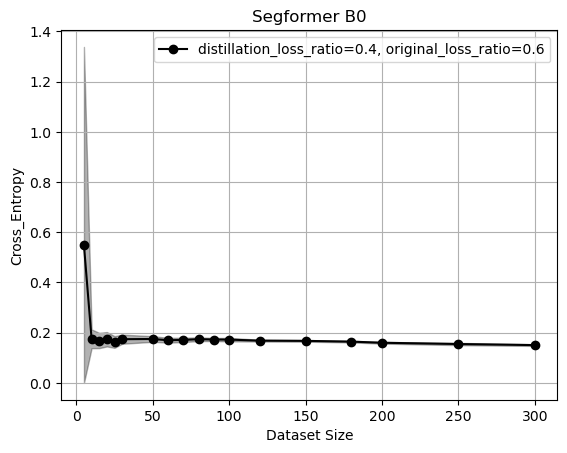

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()